In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt

In [5]:
os.listdir('../CrossStudyCompletion')

[]

In [4]:
flu_df = pd.read_csv("../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv", sep=',')
sera = flu_df['Measurements (Sera in Rows/Viruses in Columns)'].tolist()
sera_tables = [i[i.index('Table'):] for i in sera]
table_keys = set(sera_tables)
flu_df['sera_table'] = sera_tables
flu_table_dict = {table_key: flu_df.loc[flu_df['sera_table']==table_key] for table_key in table_keys}

FileNotFoundError: [Errno 2] No such file or directory: '../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv'

In [266]:
sum([i.shape[0] for i in list(flu_table_dict.values())])

1147

In [260]:
flu_df

,Measurements (Sera in Rows/Viruses in Columns),A/AUCKLAND/20/2003,A/AUCKLAND/5/96,A/BANGKOK/1/97,A/BEIJING/32/92,A/BRISBANE/10/2007,A/BRISBANE/22/94,A/BRISBANE/22/96,A/BRISBANE/3/2005,A/BRISBANE/342/2003,...,RG145K_NL/178/95,VN015/EL134/2008,VN016/EL135/2008,VN017/EL140/2008,VN018/EL204/2009,VN019/EL442/2010,VN020/EL443/2010,VN021/EL444/2010,VN053/2010,sera_table
0,Serum_A/WELLINGTON/25/93_TableS1,5,40,40,640,5,1280,160,5,5,...,160,*,*,*,*,*,*,*,*,TableS1
1,Serum_A/WELLINGTON/96/93_TableS1,5,20,40,160,5,2560,160,5,5,...,320,*,*,*,*,*,*,*,*,TableS1
2,Serum_A/VICTORIA/9/94_TableS1,5,40,40,160,5,5120,320,5,5,...,5,*,*,*,*,*,*,*,*,TableS1
3,Serum_A/JOHANNESBURG/33/94_TableS1,20,20,80,40,5,1280,320,5,5,...,320,*,*,*,*,*,*,*,*,TableS1
4,Serum_A/SHANDONG/9/93_TableS1,10,20,80,320,5,1280,160,5,5,...,80,*,*,*,*,*,*,*,*,TableS1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,SubjectA028_Post_TableS14,*,10,*,*,*,20,*,*,*,...,*,*,40,*,*,*,*,*,20,TableS14
1143,SubjectA020_Post_TableS14,*,10,*,*,*,20,*,*,*,...,*,*,20,*,*,*,*,*,5,TableS14
1144,SubjectB025_Post_TableS14,*,80,*,*,*,320,*,*,*,...,*,*,20,*,*,*,*,*,20,TableS14
1145,SubjectB040_Post_TableS14,*,20,*,*,*,80,*,*,*,...,*,*,40,*,*,*,*,*,20,TableS14


In [283]:
def non_trivialize_df(df):
    # Search columns for trivial feature (virus)
    dropped = 0
    for idx, col in enumerate(df.columns):
        uniques = df[col].unique()
        num_unique = len(uniques)
        if num_unique == 1 and 'sera_table' not in col and "*" in uniques: # Critereon for a missing virus
#             print(idx, col, num_unique, uniques)
            df = df.drop(columns=col)
            dropped += 1 # Count dropped virus
    # Search rows for trivial entry (serum)
    for idx in list(df.index):
        num_unique = len(df.loc[idx].unique())
        if num_unique == 3: # Serum name and table name are 2 constant features.
#             print(idx, num_unique)
            df = df.drop(index=idx)
    df = df.replace("*", np.nan)
    df = df.set_index('Measurements (Sera in Rows/Viruses in Columns)')
    df = df.drop(['sera_table'], axis=1)
    df = df.map(lambda x: pd.to_numeric(x, errors='coerce') )
    # Return data and number of dropped viruses
    return df, dropped


def plot_heatmap(df):
    mask = df.isnull()
    g = sns.heatmap(df, cmap='gray',mask=mask)
    g.set_facecolor('xkcd:salmon')
    return g


def plot_heatmap_subplot(table_dict):
#     keys = sorted(list(table_dict.keys()))
    keys = ["TableS1", "TableS3", "TableS5", "TableS6", "TableS13", "TableS14"]
    N = len(keys)
    fig, axs = plt.subplots(nrows=1, ncols=N, figsize=(30, 5))
    for idx, key in enumerate(keys):
        df, dropped_viruses = table_dict[key]
        percent_missing = sum(list(df.isna().sum())) / (df.shape[0] * df.shape[1]) # Proportion of missing vals in table
        df = np.log(df)
        sera_num = df.shape[0]
        virus_num = df.shape[1]
        mask = df.isnull()
        g = sns.heatmap(df,
                        xticklabels=False,
                        yticklabels=False,
                        cmap='gray',
                        mask=mask,
                        ax=axs[idx])
        g.set_facecolor('xkcd:salmon')
        axs[idx].set_xlabel(f'{sera_num} Sera x {virus_num} Viruses\n{percent_missing * 100:.2f}% Missing')
        axs[idx].set_title(key)
    return fig, axs

In [285]:
filtered_flu_table_dict = {key: non_trivialize_df(arg) for key, arg in list(flu_table_dict.items())}

(<Figure size 3000x500 with 12 Axes>,
 array([<Axes: title={'center': 'TableS1'}, xlabel='35 Sera x 74 Viruses\n13.20% Missing', ylabel='Measurements (Sera in Rows/Viruses in Columns)'>,
        <Axes: title={'center': 'TableS3'}, xlabel='324 Sera x 57 Viruses\n37.20% Missing', ylabel='Measurements (Sera in Rows/Viruses in Columns)'>,
        <Axes: title={'center': 'TableS5'}, xlabel='212 Sera x 70 Viruses\n7.06% Missing', ylabel='Measurements (Sera in Rows/Viruses in Columns)'>,
        <Axes: title={'center': 'TableS6'}, xlabel='256 Sera x 70 Viruses\n8.50% Missing', ylabel='Measurements (Sera in Rows/Viruses in Columns)'>,
        <Axes: title={'center': 'TableS13'}, xlabel='160 Sera x 20 Viruses\n0.44% Missing', ylabel='Measurements (Sera in Rows/Viruses in Columns)'>,
        <Axes: title={'center': 'TableS14'}, xlabel='160 Sera x 20 Viruses\n1.09% Missing', ylabel='Measurements (Sera in Rows/Viruses in Columns)'>],
       dtype=object))

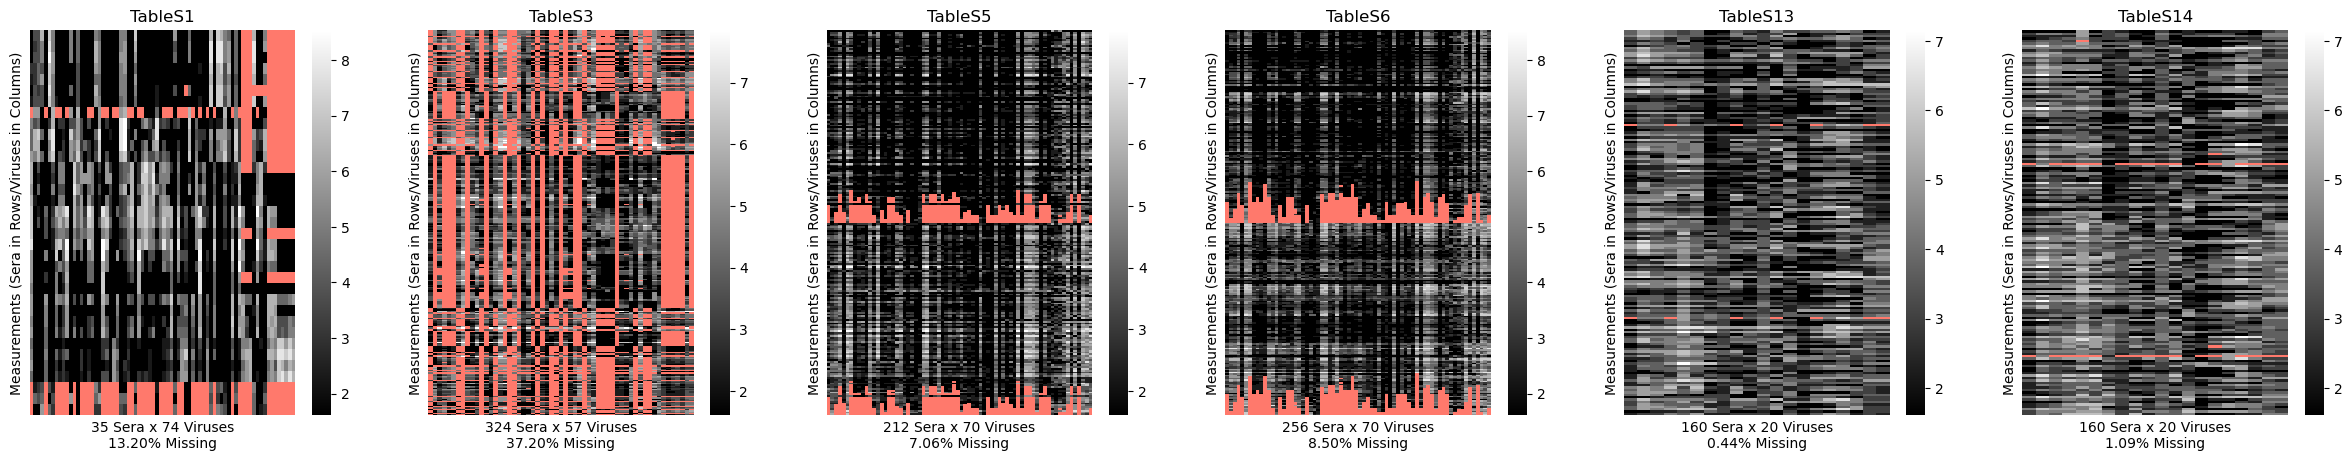

In [286]:
plot_heatmap_subplot(filtered_flu_table_dict)